# Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks which solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success, that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to this questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial we use insights and tools from machine learning to build step-by-step a spiking neural network. Specifically, we set out with the goal of building a spiking network model which solves a real-world problem. To that end, we focus on a simple classification problem and use supervised learning in conjunction with aforementioned back-propagation of error. To do this, we have to overcome yet another vanishing gradient problem linked to the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to discrete time recurrent neural network (RNN). We will used this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

# Mapping LIF neurons to RNN dynamics

The de facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i}{\mathrm{d}t} = -(U_i-U_\mathrm{rest}) + RI_i$$
where $U_i$ is the membrane potential of neuron $i$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i(t)=\sum_k \delta(t-t_j^k)$$ for the spike train (ie. the sum of all spikes) emitted by neuron $i$. Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of neuron $i$.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j(t)$$
where we have introduced the synaptic weight matrix $W_{ij}$ and the synaptic decay time constant $\tau_\mathrm{syn}$.

To make the link to RNNs apparent, we will now express above equations in discrete time. For brevity we now set the following natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike we start by noting that we can set
$$S_i(t)=\Theta(U_i(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i(t+1) = \alpha I_i(t) + \sum_j W_{ij} S_j(t)$$
with the decay constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i(t+1) = \underbrace{\beta U_i(t)}_{\mathrm{leak}} + \underbrace{I_i(t)}_{\mathrm{synaptic}} -\underbrace{S_i(t)}_{\mathrm{reset}}$$
with $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.

These equations now make the RNN character of the spiking neurons apparent. Their action can be summarized in a RNN computational graph shown on the right. Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($x$). These inputs sequentially influence the synaptic currents $I_i$, membrane potentials the $U_i$, and finally the spiking output $S_i$.  Moreover, dynamic quantities have a direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity. All quantities can be thought of as vector quantities.

Because the above expressions can be unrolled in time and as such should be amenable to network training using back-propagation through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now let us  start by implementing the above dynamics in a three layer spiking neural network in PyTorch.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
# import torchvision

In [2]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

In [3]:
# TODO make network sketch

In [4]:
# Here we specify the sizes of the network we want to build
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

batch_size = 256
nb_steps = 200

In [5]:
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=3.0/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=3.0/np.sqrt(nb_hidden))

print("done")

done


In [6]:
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
prob = 1e-2
test_input = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
test_input[mask<prob] = 1.0

Text(0,0.5,'Unit')

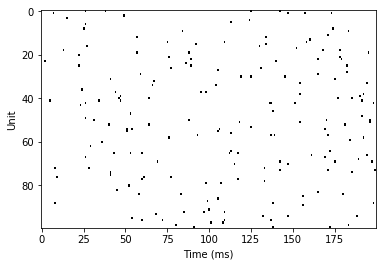

In [7]:
plt.imshow(test_input[0].t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")

In [8]:
time_step = 1e-3
tau_mem = 10e-3
tau_syn = 5e-3

dcy_mem = float(np.exp(-time_step/tau_mem))
scl_mem = 1.0-dcy_mem

dcy_syn = float(np.exp(-time_step/tau_syn))
scl_syn = 1.0-dcy_syn

In [9]:
class SuperSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    beta = 100.0 # beta is the temperature parameter of the local surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.beta*torch.abs(input)+1.0)**2
        return grad
    
sprspk  = SuperSpike.apply

In [10]:
inputs = test_input

h1 = torch.einsum("abc,cd->abd", (inputs, w1))
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

mem_rec = [mem]
spk_rec = [mem]

for t in range(nb_steps):
    mthr = mem-1.0
    out = sprspk(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    
    new_syn = dcy_syn*syn +scl_syn*h1[:,t]
    new_mem = dcy_mem*mem +syn -rst
    
    mem = new_mem
    syn = new_syn
    
    mem_rec.append(mem)
    spk_rec.append(out)

mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

In [11]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

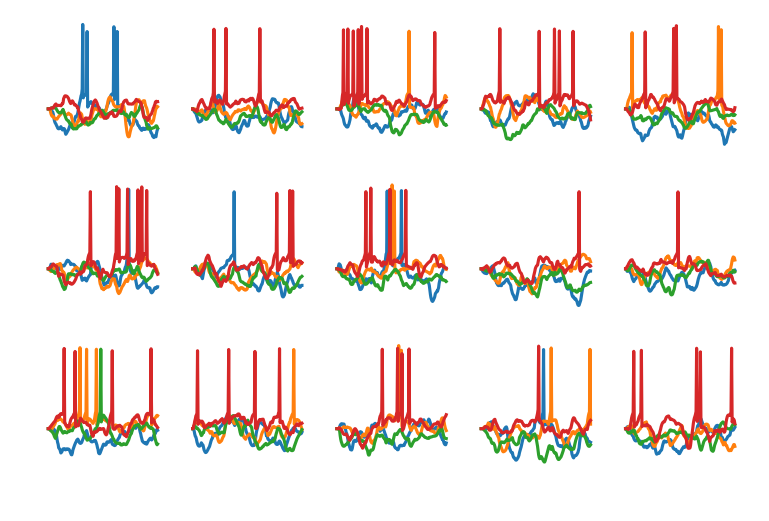

In [12]:
fig=plt.figure(dpi=150)
plot_voltage_traces(mem_rec, spk_rec)

# Let's add a readout layer

In [13]:
h1 = torch.einsum("abc,cd->abd", (inputs, w1))
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

mem_rec = [mem]
spk_rec = [mem]

# Compute hidden layer activity
for t in range(nb_steps):
    mthr = mem-1.0
    out = sprspk(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    
    new_syn = dcy_syn*syn +scl_syn*h1[:,t]
    new_mem = dcy_mem*mem +syn -rst
    
    mem = new_mem
    syn = new_syn
    
    mem_rec.append(mem)
    spk_rec.append(out)

mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

# Readout layer
h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
out_rec = [out]
for t in range(nb_steps):
    new_flt = dcy_syn*flt +scl_syn*h2[:,t]
    new_out = dcy_mem*flt +flt
    
    flt = new_flt
    out = new_out
    
    out_rec.append(out)
    
out_rec = torch.stack(out_rec,dim=1)

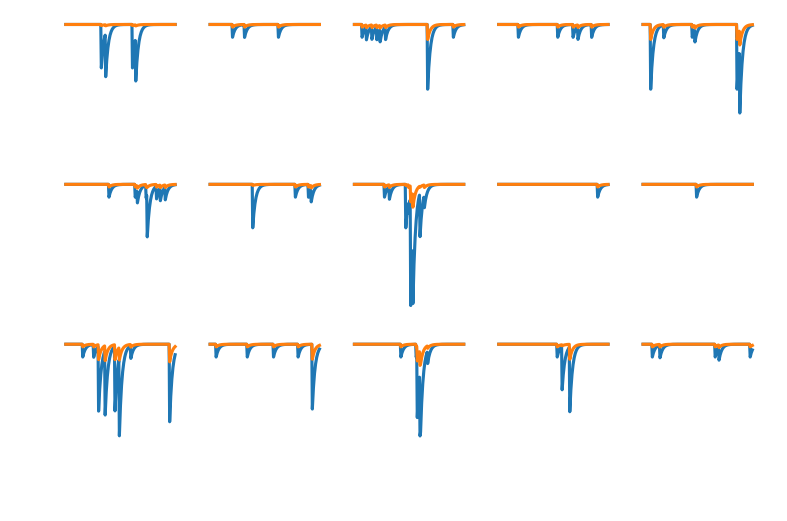

In [14]:
fig=plt.figure(dpi=150)
plot_voltage_traces(out_rec)

In [15]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = sprspk(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = dcy_syn*syn +scl_syn*h1[:,t]
        new_mem = dcy_mem*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = dcy_syn*flt +scl_syn*h2[:,t]
        new_out = dcy_mem*flt +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [16]:
target_y = torch.tensor(1*(np.random.rand(batch_size)<0.5))

In [17]:
params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=1e-2, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(test_input)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, target_y)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

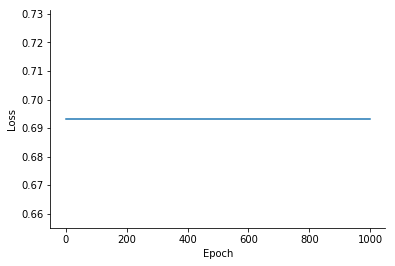

In [18]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [19]:
output,other_recordings = run_snn(test_input)
mem_rec, spk_rec = other_recordings

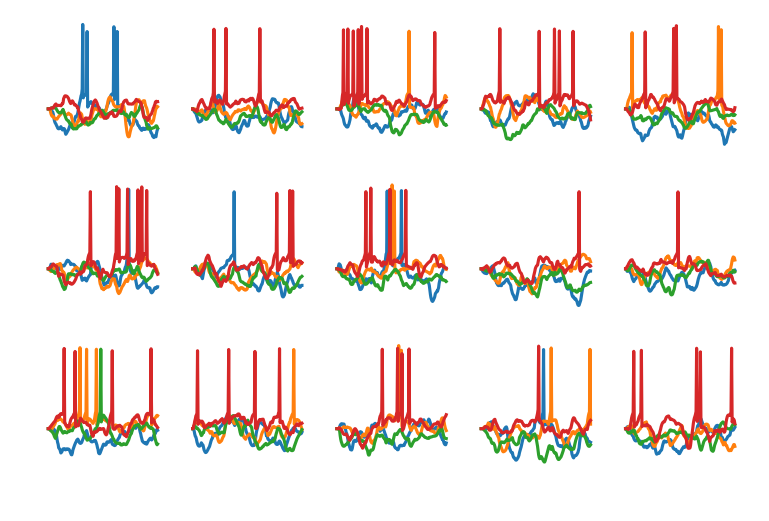

In [20]:
fig=plt.figure(dpi=150)
plot_voltage_traces(mem_rec, spk_rec)

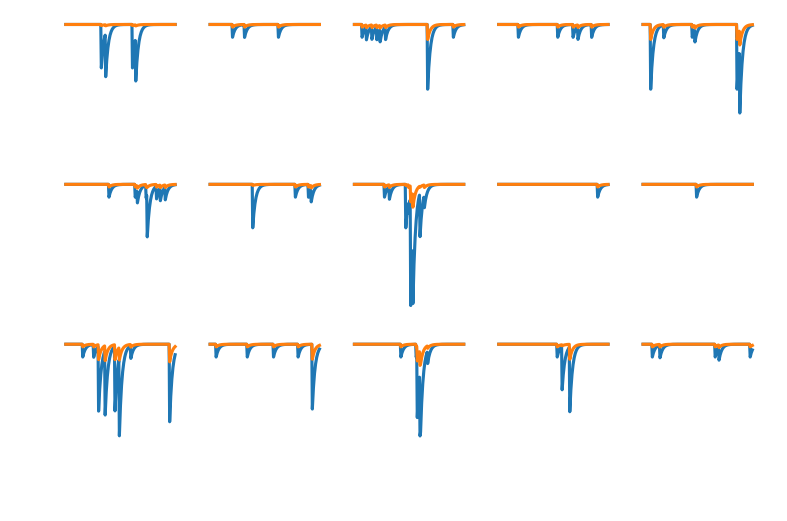

In [21]:
fig=plt.figure(dpi=150)
plot_voltage_traces(out_rec)

In [22]:
output,_ = run_snn(test_input)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((target_y==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.519531
